# 表現的評估

我們先載入這個章節範例程式碼中會使用到的第三方套件、模組或者其中的部分類別、函式。

In [1]:
from pyvizml import CreateNBAData
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## 如何評估機器學習演算方法

評估機器學習演算方法是否能夠針對特定任務（包含數值預測、類別預測）運作，必須設計能夠量化演算方法表現的指標。評估迴歸模型與分類器表現的指標與尋找係數向量 $w$ 藉此創建出 $h(X; w)$ 的原理相同，差別在於究竟要比對哪一組目標向量 $y$？

我們找尋係數向量的依據，乃是基於最小化 $y^{(train)}$ 與 $\hat{y}^{(train)}$ 之間的誤差，，其中數值預測任務是以均方誤差（Mean squared error, MSE）來表示，$m$ 代表觀測值筆數。

\begin{equation}
Minimize \; \frac{1}{m}\sum_{i}{(y^{(train)}_i - \hat{y_i}^{(train)})^2}
\end{equation}

類別預測任務則是以誤分類數（Error）來表示。

\begin{equation}
Minimize \; \sum_{i} \mid y^{(train)}_i \neq \hat{y_i}^{(train)} \mid
\end{equation}

這是因為機器學習**假設**存在了一個函式 $f$ 能夠完美描述特徵矩陣與目標向量的關係，但我們不能夠將**假設**存在的 $f$ 拿來與創建出的 $h$ 擺在桌面上比較，因此藉由比較 $y^{(train)}$ 與 $\hat{y}^{(train)}$ 來達成。評估迴歸模型與分類器的表現同樣是比較預測目標向量與實際目標向量之間的誤差，但是改為驗證資料或測試資料的目標向量。數值預測任務的表現評估以均方誤差衡量，$m$ 代表觀測值筆數。

\begin{equation}
MSE_{valid} = \frac{1}{m}\sum_{i}{(y^{(valid)}_i - \hat{y_i}^{(valid)})^2}
\end{equation}

類別預測任務的表現評估以誤分類數衡量。

\begin{equation}
Error_{valid} = \sum_{i} \mid y^{(valid)}_i \neq \hat{y_i}^{(valid)} \mid
\end{equation}

機器學習專案中的訓練、驗證來自具備已實現數值或標籤資料集，測試則來自未實現數值或標籤資料集；迴歸模型與分類器在從未見過的測試資料上之表現將決定它被部署到正式環境開始運作時的成敗，在現實世界中要評估機器學習演算方法在測試資料上的表現，在時間與金錢成本上都比在驗證資料上實施來得高出許多，像是設計類似實驗組與對照組的測試環境、等待一段時間才會實現數值或標籤。

挑選機器學習演算方法的評估指標除了與任務種類相關，也與模型的應用場景有關，例如即便同屬於疾病的檢測分類模型，針對傳染疾病或罕見疾病所選擇的指標就有可能不同，這是由於和「誤分類」所衍生出的成本連動所致。

## 評估數值預測任務的表現

數值預測任務的表現評估以均方誤差來衡量 $y^{(valid)}$ 與 $\hat{y}^{(valid)}$ 之間的差異，均方誤差愈大推論 $h_w$ 跟 $f$ 的相似度愈低，反之均方誤差愈小推論 $h$ 與 $f$ 的相似度愈高。使用 Scikit-Learn 定義好的 `mean_squared_error` 函式可以協助我們計算兩個目標向量之間的均方誤差。

In [2]:
# create_player_stats_df() 方法要對 data.nba.net 發出數百次的 HTTP 請求，等待時間會較長，要請讀者耐心等候
cnd = CreateNBAData(season_year=2019)
player_stats = cnd.create_player_stats_df()

Creating players df...
Creating players df...
Creating player stats df...


In [3]:
X = player_stats['heightMeters'].values.astype(float).reshape(-1, 1)
y = player_stats['weightKilograms'].values.astype(float)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
h = LinearRegression()
h.fit(X_train, y_train)
y_pred = h.predict(X_valid)
mse_valid = mean_squared_error(y_valid, y_pred)
mse_valid

52.74701649791643

亦可以自訂均方誤差的函式。

In [4]:
def meanSquaredError(y_true, y_pred):
    error = (y_true - y_pred)
    squared_error = error**2
    mean_squared_error = np.mean(squared_error)
    return mean_squared_error

In [5]:
mse_valid = meanSquaredError(y_valid, y_pred)
mse_valid

52.74701649791643

另外一個也常被用來評估數值預測任務表現的指標是平均絕對誤差（Mean absolute error），平均絕對誤差和均方誤差相同之處在於他們都能精確捕捉預測失準的量值，無論是低估或者高估，經過平方或絕對值的運算都會成為正數被詳實地累積起來；相異之處在於均方誤差對於預測失準較多的離群值（Outliers）具有放大的效果（平方），而平均絕對誤差則不具有這樣類似加權的效果，因此當離群值在任務預測失準所衍生的成本也大幅上升的應用場景中，就比平均絕對誤差更適合使用，表示迴歸模型的選擇和調校上會傾向避免預測失準較多的情況。

使用 Scikit-Learn 定義好的 `mean_absolute_error` 函式可以協助我們計算兩個目標向量之間的平均絕對誤差。

In [6]:
mae_valid = mean_absolute_error(y_valid, y_pred)
mae_valid

5.251994295197642

亦可以自訂平均絕對誤差的函式。

In [7]:
def meanAbsoluteError(y_true, y_pred):
    error = (y_true - y_pred)
    absolute_error = np.abs(error)
    mean_absolute_error = np.mean(absolute_error)
    return mean_absolute_error

In [8]:
mae_valid = meanAbsoluteError(y_valid, y_pred)
mae_valid

5.251994295197642

## 評估類別預測任務的表現

類別預測任務的表現評估以誤分類數來衡量 $y^{(valid)}$ 與 $\hat{y}^{(valid)}$ 之間的差異，誤分類數愈多推論 $h$ 跟 $f$ 的相似度愈低，反之誤分類數愈少推論 $h$ 與 $f$ 的相似度愈高。分類器常使用的評估指標比迴歸模型為多，像是準確率（Accuracy）、精確率（Precision）、召回率（Recall）與 F1-score 等。這些評估指標乍看之下會讓我們眼花撩亂，但實際上只要能夠拆解正確分類 $y^{(valid)} = \hat{y}^{(valid)}$ 與錯誤分類 $y^{(valid)} \neq \hat{y}^{(valid)}$ 的組成，就可以理解評估分類器指標的設計哲學。

正確分類與錯誤分類各自都還能拆解成兩種情境：

- 正確分類
    - 真陰性（True negative, TN）：$y^{(valid)}=0$ 並且 $\hat{y}^{(valid)}=0$
    - 真陽性（True positive, TP）：$y^{(valid)}=1$ 並且 $\hat{y}^{(valid)}=1$
- 錯誤分類
    - 偽陰性（False negative, FN）：$y^{(valid)}=1$ 並且 $\hat{y}^{(valid)}=0$
    - 偽陽性（False positive, FP）：$y^{(valid)}=0$ 並且 $\hat{y}^{(valid)}=1$

這四種情境能夠以一個被稱作混淆矩陣（Confusion matrix）的 $2 \times 2$ 矩陣表達。

||$\hat{y}^{(valid)}=0$|$\hat{y}^{(valid)}=1$|
|---|---|---|
|$y^{(valid)}=0$|真陰性（True negative, TN）|偽陽性（False positive, FP）|
|$y^{(valid)}=1$|偽陰性（False negative, FN）|真陽性（True positive, TP）|

前述眼花撩亂的評估指標，其實都能從組成混淆矩陣的四個象限衍生而得，使用 Scikit-Learn 定義好的 `confusion_matrix` 函式可以協助我們創建兩個目標向量之間正確分類、錯誤分類所組成的混淆矩陣。

In [9]:
X = player_stats[['apg', 'rpg']].values.astype(float)
pos_dict = {
    0: 'G',
    1: 'F'
}
pos = player_stats['pos'].values
y = np.array([0 if p[0] == 'G' else 1 for p in pos])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
h = LogisticRegression()
h.fit(X_train, y_train)
y_pred = h.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
cm

array([[60, 16],
       [20, 70]])

亦可以自訂創建混淆矩陣的函式。

In [10]:
def confusionMatrix(y_true, y_pred):
    n_unique = np.unique(y_true).size
    cm = np.zeros((n_unique, n_unique), dtype=int)
    for i in range(n_unique):
        for j in range(n_unique):
            n_obs = np.sum(np.logical_and(y_true == i, y_pred == j))
            cm[i, j] = n_obs
    return cm

In [11]:
cm = confusionMatrix(y_valid, y_pred)
cm

array([[60, 16],
       [20, 70]])

準確率（Accuracy）是類別預測任務最常用的評估指標，分子是正確分類的觀測值個數，即真陰性加真陽性；分母是四個象限的觀測值個數總和，即目標向量的長度，準確率愈高代表分類器的表現愈好、反之則代表分類器的表現愈差。

\begin{equation}
Accuracy = \frac{TN + TP}{TN + TP + FN + FP}
\end{equation}

使用 Scikit-Learn 定義好的 `accuracy_score` 函式可以協助我們計算準確率。

In [12]:
accuracy = accuracy_score(y_valid, y_pred)
accuracy

0.7831325301204819

準確率的概念直觀，但是在一些狀況中並不這麼適合評估分類器的表現，像是陽性事件發生率極低的應用場景，例如罕見疾病或市場黑天鵝事件的預測任務。如果設計出一個樸素的分類器（Dummy classifier），它以目標向量中出現頻率最高的類別作為預測依據，如果以 1000 個觀測值中僅有 1 個陽性的情況舉例，準確率可以達到 0.999，是一個乍看之下非常漂亮的評估指標。

In [13]:
y_true = np.zeros(1000, dtype=int)
y_true[-1] = 1
y_pred = np.zeros(1000, dtype=int)
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.999

然而這個分類器對預測陽性事件發生率極低的任務卻是完全無用處，亦即使用準確率來評估並不適合。這時使用精確率（Precision）與召回率（Recall）來進行評估會更加適合。精確率的分子是真陽性、分母是真陽性加偽陽性，它的意涵是分類器在所有預測為陽性的觀測值中，正確預測的觀測值數為多少；召回率的分子是真陽性、分母是真陽性加偽陰性，它的意涵是分類器在所有陽性的觀測值中，正確預測的觀測值數為多少。

\begin{align}
Precision = \frac{TP}{TP + FP} \\
Recall = \frac{TP}{TP + FN}
\end{align}

相較準確率，精確率與召回率更專注評估分類器對陽性事件的預測能力，兩個指標愈高，代表模型的表現愈好。精確率如果表現要好除了真陽性高，偽陽性亦要想辦法降低，而召回率同樣若表現要好除了真陽性高，偽陰性亦要想辦法降低，因此在選擇採用精確率與召回率時，常會延伸探討偽陽性或偽陰性所衍生的誤判成本。採用精確率代表的要盡可能降低偽陽性，這表示的是偽陽性的成本高，意味著是誤判為陽性事件的成本高（例如誤診而進行高風險的手術）；採用召回率代表的是要儘可能降低偽陰性，這表示的是偽陰性的成本高，意味著是誤判為陰性事件的成本高（例如誤診而導致超級傳播者沒有隔離而進入社區）。

使用 Scikit-Learn 定義好的 `precision_score` 與 `recall_score` 函式可以協助我們計算精確率與召回率，這時可以看到樸素分類器在精確率和召回率都得到了最低的評估值。

In [14]:
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred)
print(precision)
print(recall)

0.0
0.0


評估分類模型的表現時可以同時將精確率與召回率納入考量，運用一個係數 $\beta$ 加權兩個指標合成為一個稱為 F-score 的指標。

\begin{equation}
F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}
\end{equation}

$\beta$ 係數的值可以表示對精確率或召回率的相對重視程度，如果偽陽性的成本遠高於偽陰性的成本，代表百分百重視精確率，這時代入 $\beta = 0$，F-score 就會是精確率；如果偽陰性的成本遠高於偽陽性的成本，代表百分百重視召回率，這時代入 $\beta = \infty$，F-score 就會是召回率；如果偽陽性的成本和偽陰性的成本相當，代表兩個指標同等重要，這時代入 $\beta = 1$，F-score 就被稱為 F1-score，指標愈高，代表模型的表現愈好。

\begin{equation}
F_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall}
\end{equation}

使用 Scikit-Learn 定義好的 `f1_score` 函式可以協助我們計算 F1-score，同樣可以看到樸素分類器依然在 F1-score 獲得了最低的評估值。

In [15]:
f1 = f1_score(y_true, y_pred)
f1

0.0

## 自訂計算評估指標的類別 `ClfMetrics`

我們亦可以根據混淆矩陣自訂分類器評估指標的類別。

In [16]:
class ClfMetrics:
    """
    This class calculates some of the metrics of classifier including accuracy, precision, recall, f1 according to confusion matrix.
    Args:
        y_true (ndarray): 1d-array for true target vector.
        y_pred (ndarray): 1d-array for predicted target vector.
    """
    def __init__(self, y_true, y_pred):
        self._y_true = y_true
        self._y_pred = y_pred
    def confusion_matrix(self):
        """
        This function returns the confusion matrix given true/predicted target vectors.
        """
        n_unique = np.unique(self._y_true).size
        cm = np.zeros((n_unique, n_unique), dtype=int)
        for i in range(n_unique):
            for j in range(n_unique):
                n_obs = np.sum(np.logical_and(self._y_true == i, self._y_pred == j))
                cm[i, j] = n_obs
        self._tn = cm[0, 0]
        self._tp = cm[1, 1]
        self._fn = cm[0, 1]
        self._fp = cm[1, 0]
        return cm
    def accuracy_score(self):
        """
        This function returns the accuracy score given true/predicted target vectors.
        """
        cm = self.confusion_matrix()
        accuracy = (self._tn + self._tp) / np.sum(cm)
        return accuracy
    def precision_score(self):
        """
        This function returns the precision score given true/predicted target vectors.
        """
        precision = self._tp / (self._tp + self._fp)
        return precision  
    def recall_score(self):
        """
        This function returns the recall score given true/predicted target vectors.
        """
        recall = self._tp / (self._tp + self._fn)
        return recall
    def f1_score(self, beta=1):
        """
        This function returns the f1 score given true/predicted target vectors.
        Args:
            beta (int, float): Can be used to generalize from f1 score to f score.
        """
        precision = self.precision_score()
        recall = self.recall_score()
        f1 = (1 + beta**2)*precision*recall / ((beta**2 * precision) + recall)
        return f1

In [17]:
pos = player_stats['pos'].values
y = np.array([0 if p[0] == 'G' else 1 for p in pos])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
h = LogisticRegression()
h.fit(X_train, y_train)
y_pred = h.predict(X_valid)

In [18]:
# 混淆矩陣
clf_metrics = ClfMetrics(y_valid, y_pred)
clf_metrics.confusion_matrix()

array([[60, 16],
       [20, 70]])

In [19]:
# 準確率
clf_metrics.accuracy_score()

0.7831325301204819

In [20]:
# 精確率
clf_metrics.precision_score()

0.7777777777777778

In [21]:
# 召回率
clf_metrics.recall_score()

0.813953488372093

In [22]:
# F1-score
clf_metrics.f1_score()

0.7954545454545455

## 誤差的來源

在機器學習的訓練階段，我們透過比較訓練資料中的預測目標向量與實際目標向量之間的誤差，來作為尋找係數向量的依據；在機器學習的驗證階段，我們透過比較驗證資料中的預測目標向量與實際目標向量之間的誤差，來評估模型的表現；而最後在機器學習的測試階段，我們終究要面對在前兩個階段未碰觸、尚未實現、不具備目標值或標籤的測試資料，不論是透過實驗設計或者等待一段時間讓未知資料的數值或標籤實現，最終使得機器學習演算方法表現一翻兩瞪眼的是比較測試資料中預測目標向量與實際目標向量之間的誤差階段。

數值預測任務的表現評估以均方誤差衡量，$m$ 代表觀測值筆數。

\begin{equation}
MSE_{test} = \frac{1}{m}\sum_{i}{(y^{(test)}_i - \hat{y_i}^{(test)})^2}
\end{equation}

類別預測任務的表現評估以誤分類數衡量。

\begin{equation}
Error_{test} = \sum_{i} \mid y^{(test)}_i \neq \hat{y_i}^{(test)} \mid
\end{equation}

一個訓練後的迴歸模型或分類器，其誤差來源可以大抵分為訓練誤差（Training error）與測試誤差（Test error），在已實現、具備目標值或標籤的訓練、驗證資料上表現良好，表示它的訓練誤差小；在尚未實現、不具備目標值或標籤的測試資料上表現良好，表示它的測試誤差小（又稱為泛化能力強），於是乎機器學習演算方法的目標是將訓練誤差以及測試誤差降低。不過在現實世界中，處於訓練與驗證階段時對於測試資料是一無所知的，又該如何在只能接觸到訓練與驗證資料時去降低測試誤差？仰賴訓練、驗證與測試資料的 i.i.d 假設，資料中每一筆觀測值彼此獨立（Independent）、訓練、驗證與測試資料來自同樣分佈（Identically distributed）的母體。如果假設不成立，用訓練資料產生 $h_w$ 來逼近 $f$ 的做法就顯得毫無意義了。因此我們可以將機器學習演算方法的目標修正簡化為：

1. 減少訓練誤差
2. 減少訓練誤差與測試誤差的間距

為了減少訓練誤差，我們可以透過交叉驗證（Cross validation）的技巧消弭訓練與驗證資料切割所造成的誤差、增加梯度遞減的訓練次數或者增加特徵矩陣的欄位；而為了減少訓練誤差與測試誤差的間距，我們可以引用正規化（Regularization）的技巧。

## 減少訓練誤差

在前述章節中，我們在切割訓練與驗證資料時都有納入 `random_state=42` 這是為了固定某個特定的隨機狀態，如果沒有指定這個參數，每一次資料劃分為訓練和驗證的情況都會不同，這會影響係數向量 $w$ 求解、$h_w$ 的創建進而影響 $\hat{y}$。如果希望避免某個隨機狀態劃分出了不夠均勻的訓練和驗證資料，可以使用交叉驗證的技巧，將資料拆分為 `k` 個不重複的子集合，進而可以在這些子集合上重複進行訓練和驗證，在第 `i` 次迭代中將第 `i` 個子集合當作驗證資料，其餘當作訓練資料，最後取平均值來評估誤差。

使用 Scikit-Learn 定義好的 `KFold` 類別可以協助我們獲得交叉驗證時訓練與驗證資料的位置。

In [23]:
shuffled_index = player_stats.index.values.copy()
np.random.seed(42)
np.random.shuffle(shuffled_index)
X = player_stats['heightMeters'].values.astype(float)[shuffled_index].reshape(-1, 1)
y = player_stats['weightKilograms'].values.astype(float)[shuffled_index]
kf = KFold(n_splits=5)
h = LinearRegression()
mse_scores = []
for train_index, valid_index in kf.split(X):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    h.fit(X_train, y_train)
    y_pred = h.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    mse_scores.append(mse)
mean_mse_scores = np.mean(mse_scores)
print(mse_scores)
print(mean_mse_scores)

[55.07839694995417, 51.7810202008688, 50.50037007540896, 38.95499731929424, 55.212983938023825]
50.30555369671


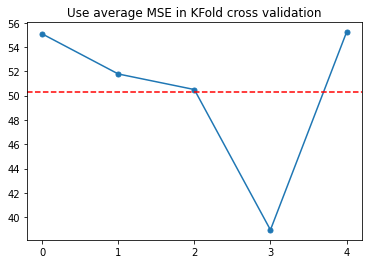

In [24]:
fig= plt.figure()
ax = plt.axes()
ax.plot(mse_scores, marker='.', markersize=10)
ax.axhline(mean_mse_scores, color='red', linestyle="--")
ax.set_title('Use average MSE in KFold cross validation')
ax.set_xticks(range(5))
plt.show()

在梯度遞減開始前隨機初始化的 $w$ 的訓練誤差是高的，隨著訓練次數增加而漸漸減少，這在數值預測與類別預測任務中我們已經看過不少範例；而增加特徵矩陣的欄位可以使用 Scikit-Learn 定義好的 `PolynomialFeatures` 類別創建高次項觀察訓練誤差在不同 `degree` 下的訓練誤差，以迴歸模型為例，當訓練誤差很高的時候模型處於「配適不足」（Underfitting）的狀態，像是 `degree=0` 的時候。

In [25]:
X = player_stats['heightMeters'].values.astype(float).reshape(-1, 1)
X_plot = np.linspace(X.min() - 0.1, X.max().max() + 0.1).reshape(-1, 1)
y = player_stats['weightKilograms'].values.astype(float)
degrees = range(9)
y_plots = []
training_errors = []
for d in degrees:
    poly = PolynomialFeatures(d)
    X_poly = poly.fit_transform(X)
    X_train, X_valid, y_train, y_valid = train_test_split(X_poly, y, test_size=0.33, random_state=42)
    h = LinearRegression()
    h.fit(X_train, y_train)
    y_pred = h.predict(X_train)
    training_error = mean_squared_error(y_train, y_pred)
    training_errors.append(training_error)
    X_plot_poly = poly.fit_transform(X_plot)
    y_pred = h.predict(X_plot_poly)
    y_plots.append(y_pred)

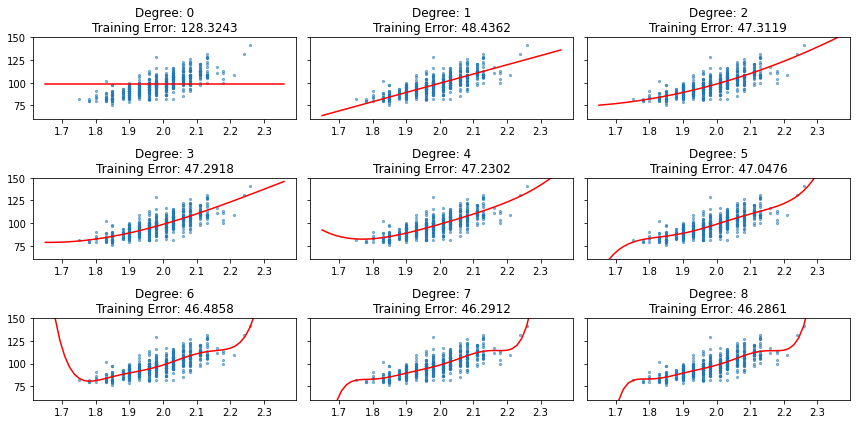

In [26]:
x = X.ravel()
fig, axes = plt.subplots(3, 3, figsize=(12, 6), sharey=True)
for k, d, te, y_p in zip(range(9), degrees, training_errors, y_plots):
    i = k // 3
    j = k % 3
    x_p = X_plot.ravel()
    axes[i, j].scatter(x, y, s=5, alpha=0.5)
    axes[i, j].plot(x_p, y_p, color="red")
    axes[i, j].set_ylim(60, 150)
    axes[i, j].set_title("Degree: {}\nTraining Error: {:.4f}".format(d, te))
plt.tight_layout()
plt.show()

除了為特徵矩陣加入更多的變數，減少訓練誤差的方式還有超參數（Hyperparameter）調校、變換其他機器學習演算方法或者製造衍生變數（特徵工程）。

## 減少訓練誤差與測試誤差的間距

在試圖減少訓練誤差的過程，很有可能伴隨而來的是驗證或測試誤差的升高，這是因為模型對於訓練資料過於熟悉，而降低了它的泛化能力。例如跑者若是固定在平坦的操場訓練，在參與路跑時候很可能因為地形起伏而導致比賽表現不如訓練，這樣的狀態我們稱之為「過度配適」（Overfitting）。欲避免過度配適最直觀的解法就是減少特徵矩陣的變數，但這又會與我們原本希望減少訓練誤差的出發點相左，有沒有什麼辦法讓機器學習演算法保留多個變數的特徵，但又不會產生過度配飾呢？這時可以求助「正規化」（Regularization）。正規化技巧是透過使用一個參數 $\lambda$ 在訓練過程中對係數向量壓抑，以數值預測任務為例，在原本的誤差函式 $J(w)$ 加上 $\lambda w^Tw$ 抑制係數向量，又被稱為 L2 正規化。

\begin{equation}
J(w) = \frac{1}{m}(\parallel Xw - y \parallel^2 + \lambda w^Tw)
\end{equation}

接著求解梯度：$J(w)$ 關於 $w$ 的偏微分。

\begin{align}
\frac{\partial J}{\partial w} &= \frac{1}{m}(\frac{\partial}{\partial w}(\parallel Xw - y\parallel^2) + \frac{\partial}{\partial w}\lambda w^Tw) \\
&= \frac{1}{m}(\frac{\partial}{\partial w}(Xw - y)^T(Xw-y) + \frac{\partial}{\partial w}\lambda w^Tw)\\
&= \frac{1}{m}(\frac{\partial}{\partial w}(w^TX^TXw - w^TX^Ty - y^TXw + y^Ty) + \frac{\partial}{\partial w}\lambda w^Tw) \\
&= \frac{1}{m}(\frac{\partial}{\partial w}(w^TX^TXw - (Xw)^Ty - (Xw)^Ty + y^Ty) + \frac{\partial}{\partial w}\lambda w^Tw)\\
&= \frac{1}{m}(\frac{\partial}{\partial w}(w^TX^TXw - 2(Xw)^Ty + y^Ty) + \frac{\partial}{\partial w}\lambda w^Tw) \\
&= \frac{1}{m}(2X^TXw - 2X^Ty + 2\lambda w) \\
&= \frac{2}{m}(X^TXw - X^Ty + \lambda w) \\
&= \frac{2}{m}(X^T(Xw - y) + \lambda w)) \\
&= \frac{2}{m}(X^T(\hat{y} - y) + \lambda w))
\end{align}

就可以寫出具備 L2 正規化效果梯度遞減的式子。

\begin{gather}
w := w - \alpha \frac{2}{m}(X^T(\hat{y} - y) + \lambda w)) \\
w := (w - \alpha \frac{2}{m}\lambda w) - \alpha\frac{2}{m}X^T(\hat{y} - y) \\
w := w(1 - \alpha \frac{2}{m}\lambda) - \alpha\frac{2}{m}X^T(\hat{y} - y)
\end{gather}

$\lambda$ 是由使用者決定的參數，當 $\lambda = 0$ 時代表不抑制係數向量，沒有正規化效果；較大的 $\lambda$ 會壓抑最適化係數向量的選擇，正規化效果大，藉此在配適不足與過度配適之間進行平衡，當正規化效果過大時，模型又會變得與配適不足的狀態相近。使用 Scikit-Learn 定義好的 `Ridge` 類別可以協助我們建構具備 L2 正規化效果的迴歸模型，正規化效果由 `alpha` 參數決定，愈大表示正規化效果愈強。

In [27]:
X = player_stats['heightMeters'].values.astype(float).reshape(-1, 1)
y = player_stats['weightKilograms'].values.astype(float)
poly = PolynomialFeatures(9)
X_plot = np.linspace(X.min() - 0.1, X.max().max() + 0.1).reshape(-1, 1)
X_poly = poly.fit_transform(X)
X_plot_poly = poly.fit_transform(X_plot)
X_train, X_valid, y_train, y_valid = train_test_split(X_poly, y, test_size=0.33, random_state=42)
alphas = [0, 1, 10, 1e3, 1e5, 1e6, 1e7, 1e8, 1e9]
y_plots = []
for alpha in alphas:
    h = Ridge(alpha=alpha)
    h.fit(X_train, y_train)
    y_pred = h.predict(X_train)
    y_pred = h.predict(X_plot_poly)
    y_plots.append(y_pred)

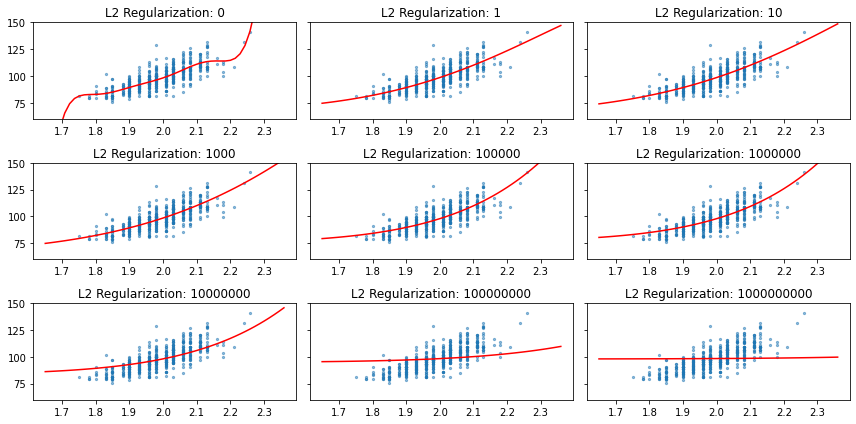

In [28]:
x = X.ravel()
fig, axes = plt.subplots(3, 3, figsize=(12, 6), sharey=True)
for k, alpha, y_p in zip(range(9), alphas, y_plots):
    i = k // 3
    j = k % 3
    x_p = X_plot.ravel()
    axes[i, j].scatter(x, y, s=5, alpha=0.5)
    axes[i, j].plot(x_p, y_p, color="red")
    axes[i, j].set_ylim(60, 150)
    axes[i, j].set_title("L2 Regularization: {:.0f}".format(alpha))
plt.tight_layout()
plt.show()

同樣在類別預測任務於原本的誤差函式 $J(w)$ 也能夠加上 $\lambda w^Tw$ 抑制係數向量。

\begin{equation}
J(w) = \frac{1}{m}(-ylog(\sigma(Xw)) - (1-y)log(1-\sigma(Xw)) + \lambda w^Tw)
\end{equation}

接著求解梯度：$J(w)$ 關於 $w$ 的偏微分。

\begin{align}
\frac{\partial J}{\partial w} &= \frac{1}{m}(-y(1-\sigma(Xw))X - (1-y)(-\sigma(Xw)X) + 2\lambda w) \\
&=\frac{1}{m}(-X^Ty + y\sigma(Xw)X + X^T\sigma(Xw) - y\sigma(Xw)X + 2\lambda w) \\
&=\frac{1}{m}(-X^Ty + X^T\sigma(Xw) + 2\lambda w) \\
&=\frac{1}{m}(X^T(\sigma(Xw) - y) + 2\lambda w) \\
&=\frac{1}{m}(X^T(\sigma(Xw) - y) + \frac{1}{C}w) \text{, where } C=\frac{1}{2\lambda}
\end{align}

就可以寫出具備 L2 正規化效果梯度遞減的式子。

\begin{gather}
w := w - \alpha \frac{1}{m}(X^T(\sigma(Xw) - y) + \frac{1}{C}w) \text{, where } C=\frac{1}{2\lambda} \\
w := w - \alpha \frac{1}{mC}w - \alpha \frac{1}{m}(X^T(\sigma(Xw) - y)) \\
w := w(1 - \alpha \frac{1}{mC}) - \alpha \frac{1}{m}(X^T(\sigma(Xw) - y))
\end{gather}

Scikit-Learn 的 `LogisticRegression` 類別中的參數 `C` 與 L2 正規化 $\lambda$ 參數是倒數關係 $C=\frac{1}{2\lambda}$，當 `C` 愈大表示正規化效果愈低，反之 `C` 愈小表示正規化效果愈高，這也是為什麼在類別預測的任務章節中，為了和自訂類別 `LogitReg` 比較需要設定一個很大的 `C` 來讓正規化效果降到很低。

## 延伸閱讀

1. Machine Learning Basics. In: Ian Goodfellow ,Yoshua Bengio, and Aaron Courville, Deep Learning (https://www.amazon.com/Deep-Learning-Adaptive-Computation-Machine/dp/0262035618/)
2. Training Models. In: Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/)
3. Best Practices for Model Evaluation and Hyperparameter Tuning. In: Sebastian Raschka, Vahid Mirjalili, Python Machine Learning (https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow/dp/1789955750/)
4. Confustion matrix (https://en.wikipedia.org/wiki/Confusion_matrix)
5. Regularization (https://en.wikipedia.org/wiki/Regularization_(mathematics))